## Setup

In [51]:
import sys
import pandas as pd

import paths
import pickle

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from models import train_alt, CNN1D, CNN2D

import matplotlib.pyplot as plt

In [52]:
# A helper function to subset 30S, since now the surface vars exist for all longitudes - values taken from basin function!
def mask_30S(inputs):
    mask = np.logical_or(np.logical_or(np.logical_and(inputs.longitude >= -180, 
                                                      inputs.longitude <= -71),
                                       np.logical_and(inputs.longitude >= 31, 
                                                      inputs.longitude <= 115)),
                         np.logical_and(inputs.longitude >= 153, 
                                        inputs.longitude <= 180))
    masked = inputs.where(mask, drop = True)

    return masked

In [53]:
# A helper function to format the input files based on a given latitude
def format_lat_lon(value):
    """Format latitude or longitude with N/S or E/W suffix."""
    if value < 0:
        return f"{abs(value)}S"
    else:
        return f"{value}N"

## Experiment Variables

In [237]:
data_home = paths.LOCAL_DIR
lats = [26, -30, -55, -60]
lat = lats[3]

## Loading and processing relevant data

In [231]:
# Retrieve the input covariates (ecco surface variables)
inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}.nc").isel(latitude=slice(1,2))
#inputs = mask_30S(inputs)  # when working at 30S, they have to be masked, otherwise not
inputs

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 1, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -59.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 ...
    ZWS        (time, latitude, longitude) float32 ...
    OBP        (time, latitude, longitude) float32 ...
    SSS        (time, latitude, longitude) float32 ...
    SST        (time, latitude, longitude) float32 ...

In [232]:
# Retrieve the output streamfunctions to train on (in density space)
outputs_fp = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_moc_density.pickle"

with open(outputs_fp, 'rb') as f:
    outputs = pickle.load(f).astype(np.float64)
outputs = np.expand_dims(outputs, 1) # grabbing just 30S

outputs = xr.Dataset(
            data_vars = {'moc' : (["time", "latitude"], outputs)}, 
            coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(-60),}
        )

outputs

<xarray.Dataset>
Dimensions:   (time: 312, latitude: 1)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude  (latitude) int32 -60
Data variables:
    moc       (time, latitude) float64 -13.38 -14.45 -6.522 ... 2.564 -15.85

In [233]:
# Align the dates according to the data available for in- and output
date_range = (inputs.time.values[0], inputs.time.values[-1]) # grabbing start and end date for inputs
date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
print('Date range to align to:', date_range)
inputs, outputs = align_inputs_outputs(inputs, outputs, date_range = date_range, ecco=False)

Date range to align to: ('1992-01-16', '2017-12-16')


In [234]:
# apply whatever preprocessing we want *before* calling reshape_inputs
pp_data = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=False,
                              remove_trend=False,
                              standardize=True,
                              lowpass=False)

# reshape as desired and convert to a numpy array
pp_data_np = reshape_inputs(pp_data, history=6, keep_coords=["time"])
X = pp_data_np

# Re-organise the data to do convolutions along the correct axis (necessary in PyTorch)
dims = list(range(X.ndim))  
dims[1], dims[-1] = dims[-1], dims[1]
X = np.transpose(X, dims)

# Make sure the dimensions align well with the network (1D/2D CNN)
conv_dims = 1
if len(X.shape) == (conv_dims + 1):
    X = np.expand_dims(X, axis=-1)

# MOC strength from data
strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=False,
                               remove_trend=False,
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values
y = strength_np[-X.shape[0]:]

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)

axes: ['time', 'history', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (307, 6, 5)

Inputs shape: (307, 5, 6)
Outputs shape: (307,)


In [235]:
# Define the train, validation and test set and convert them all into tensors for PyTorch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None, random_state=123456)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, stratify=None, random_state=123456)

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"device: {device}")

Xt_train = t.tensor(X_train, device=device).double()
Yt_train = t.tensor(y_train, device=device).double()
Xt_valid = t.tensor(X_valid, device=device).double()
Yt_valid = t.tensor(y_valid, device=device).double()
Xt_test = t.tensor(X_test, device=device).double()
Yt_test = t.tensor(y_test, device=device).double()

device: cpu


## Running Neural Networks Trainings

In [ ]:
# Hyperparameters to tune
dropout = 0.2
n_pure_layers = 1
n_mix_layers = 2
n_channels_mult = 7
kernel_size = 3                 #For 2D input change this to (3x3)
model_iterations = 3

In [239]:
import importlib
importlib.reload(train_alt)

<module 'models.train_alt' from 'C:\\Users\\aline\\OTP\\models\\train_alt.py'>

device: cpu
4691 parameters.


100%|██████████| 5000/5000 [00:43<00:00, 116.15it/s]


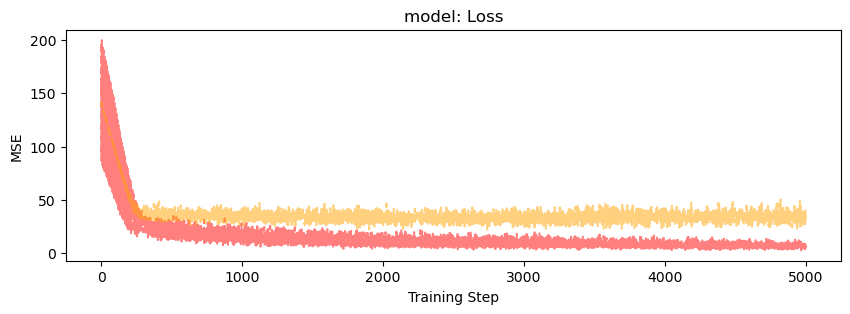

device: cpu
4691 parameters.


100%|██████████| 5000/5000 [00:40<00:00, 122.28it/s]


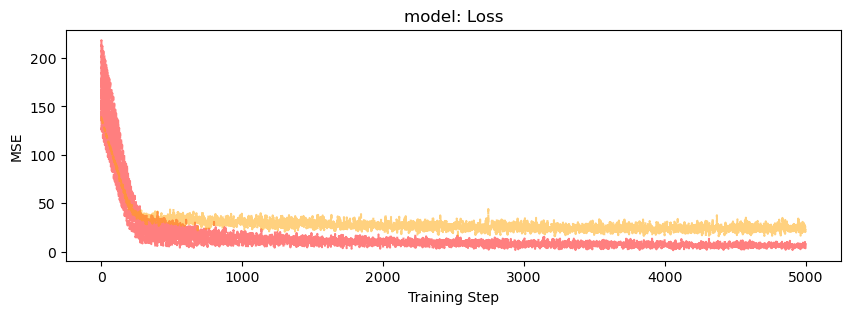

device: cpu
4691 parameters.


100%|██████████| 5000/5000 [01:06<00:00, 75.17it/s] 


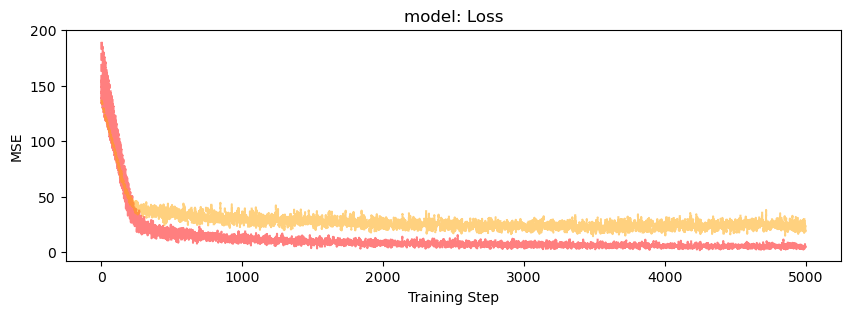

In [241]:
# One training loop with validation 
def train_CNN():

    n_features = X.shape[1]
    model = CNN1D.CNN1D(
        n_pure_layers=n_pure_layers, 
        n_mix_layers=n_mix_layers, 
        n_features=n_features, 
        n_channels=n_features*n_channels_mult,
        kernel_size=kernel_size,
        dropout=dropout
    ).double()

    model, train_loss, val_loss = train_alt.train_model(
        model=model, 
        X_train = Xt_train, 
        y_train = Yt_train, 
        X_val = Xt_valid,
        y_val = Yt_valid, 
        early_stopping=True,
        patience=500,
        plot_loss=True,
    )
    return model

# Run the training multiple times to assess the variation
models = []
for i in range(model_iterations):
    models.append(train_CNN())

In [238]:
def predict_CNN(model):

    # Extracting all predictions in time order
    train_set_pred = train_alt.predict(model, Xt_train, Yt_train)
    valid_set_pred = train_alt.predict(model, Xt_valid, Yt_valid)
    test_set_pred = train_alt.predict(model, Xt_test, Yt_test)
    
    predictions = {
        "train_set_pred": train_set_pred, 
        "valid_set_pred": valid_set_pred, 
        "test_set_pred": test_set_pred, 
        "all_preds": np.concatenate([train_set_pred, valid_set_pred, test_set_pred])
    }
    
    metrics = {
        "r2": round(r2_score(test_set_pred, y_test), 3),
        "mse": round(mean_squared_error(test_set_pred, y_test), 3),
        "rmse": round(root_mean_squared_error(test_set_pred, y_test), 3),
        "mae": round(mean_absolute_error(test_set_pred, y_test), 3),
        "mape": round(mean_absolute_percentage_error(test_set_pred, y_test), 3)*100,
        "cmape": round(custom_MAPE(np.array(test_set_pred).squeeze(), y_test, threshold=0.5), 3)*100,
        "test_corr": round(np.corrcoef(np.array(test_set_pred).squeeze(), y_test)[0, 1], 3),
        "train_corr": round(np.corrcoef(np.array(train_set_pred).squeeze(), y_train)[0, 1], 3)
        }
    
    return predictions, metrics

# For each of the trained models, retrieve the predictions and according metrics
predictions, metrics = zip(*[predict_CNN(model) for model in models])

summary_metrics_df = pd.DataFrame(metrics).agg(['mean', 'std']).round(3).T
display(summary_metrics_df)

,mean,std
r2,0.565,0.054
mse,24.380,4.298
rmse,4.925,0.436
mae,4.112,0.541
mape,63.133,10.281
cmape,57.700,0.917
test_corr,0.794,0.019
train_corr,0.967,0.001


## Output visualisation

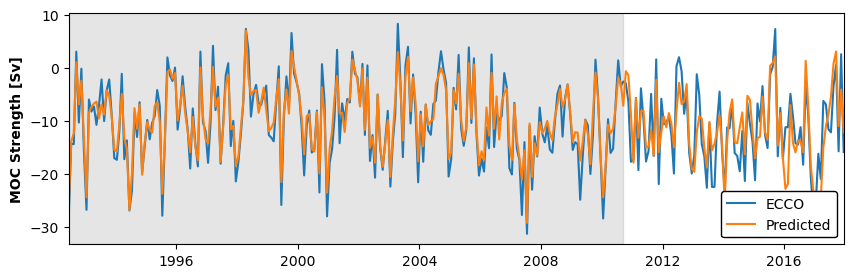

In [228]:
predictions_df = pd.DataFrame(predictions)
mean_y = {col: np.mean(np.stack(predictions_df[col].values), axis=0) for col in predictions_df}

time = outputs.time.values[-X.shape[0]:]
fig, ax = timeseries_comparison(mean_y['all_preds'], y, time, len(X_train))
plt.show()

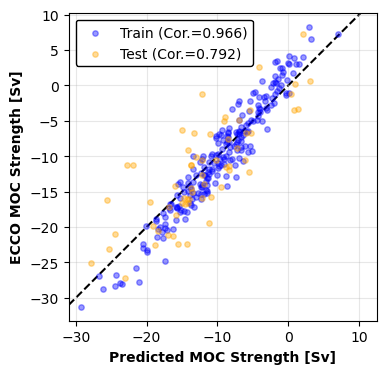

In [229]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(mean_y['train_set_pred']).squeeze()
y_pred_test = np.array(mean_y['test_set_pred']).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()